### Setup environment

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten 
from tensorflow.keras.datasets import mnist
import numpy as np 
import matplotlib
import matplotlib.pyplot as plt 
import sklearn
from sklearn.metrics import roc_auc_score 
import mlflow
import mlflow.tensorflow

2025-09-02 15:22:34.503533: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-09-02 15:22:34.585626: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-09-02 15:22:38.729915: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.


In [2]:

print("TensorFlow: {}".format(tf.__version__))
print("Scikit-Learn: {}".format(sklearn.__version__))
print("Numpy: {}".format(np.__version__))
print("MLFlow: {}".format(mlflow.__version__))
print("Matplotlib: {}".format(matplotlib.__version__))

TensorFlow: 2.20.0
Scikit-Learn: 1.7.1
Numpy: 2.3.2
MLFlow: 3.3.2
Matplotlib: 3.10.6


In [3]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Class:  5


(<matplotlib.image.AxesImage at 0x7f30f62f7620>, None)

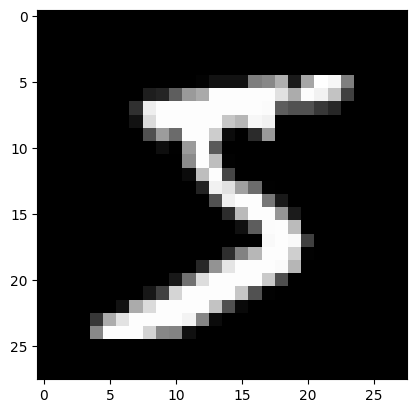

In [4]:
plt.imshow(x_train[0], cmap='gray'), print("Class: ", y_train[0])

In [5]:
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1],
x_train.shape[2], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1],
x_test.shape[2], 1)
y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)

In [6]:
print("Shapes")
print("x_train: {}\ny_train: {}".format(x_train.shape,y_train.shape))
print("x_test: {}\ny_test: {}".format(x_test.shape,y_test.shape))

Shapes
x_train: (60000, 28, 28, 1)
y_train: (60000, 10)
x_test: (10000, 28, 28, 1)
y_test: (10000, 10)


### MLFlow Run - Training and Evaluation

In [7]:
model = Sequential()
model.add(Conv2D(filters=16, kernel_size=3, strides=2,padding='same', input_shape=(28, 28, 1), activation="relu"))
model.add(Conv2D(filters=8, kernel_size=3, strides=2,padding='same', input_shape=(28, 28, 1), activation="relu"))
model.add(Flatten())
model.add(Dense(30, activation="relu"))
model.add(Dense(20, activation="relu"))
model.add(Dense(10, activation="softmax"))
model.summary()

/home/user/Bureau/MLflow-Workshop/mlflow_env/lib/python3.13/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-09-02 15:23:01.356869: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 14, 14, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 7, 7, 8)        │         1,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 392)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 30)             │        11,790 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 20)             │           620 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │           210 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,940 (54.45 KB)

 Trainable params: 13,940 (54.45 KB)

 Non-trainable params: 0 (0.00 B)

In [8]:
model.compile(optimizer="Adam",loss="categorical_crossentropy", metrics=["accuracy"])

In [10]:
mlflow.set_tracking_uri('http://localhost:8080')
mlflow.set_experiment("TF_Keras_MNIST") 

2025/09/02 15:23:23 INFO mlflow.tracking.fluent: Experiment with name 'TF_Keras_MNIST' does not exist. Creating a new experiment.


<Experiment: artifact_location='mlflow-artifacts:/930019721520858578', creation_time=1756819403058, experiment_id='930019721520858578', last_update_time=1756819403058, lifecycle_stage='active', name='TF_Keras_MNIST', tags={}>

In [16]:
with mlflow.start_run():
    mlflow.tensorflow.autolog()
    model.fit(x=x_train, y=y_train, batch_size=256, epochs=10)
    preds = model.predict(x_test)
    preds = np.round(preds)
    eval_acc = model.evaluate(x_test, y_test)[1]
    auc_score = roc_auc_score(y_test, preds)
    print("eval_acc: ", eval_acc)
    print("auc_score: ", auc_score)
    mlflow.tensorflow.mlflow.log_metric("eval_acc", eval_acc)
    mlflow.tensorflow.mlflow.log_metric("auc_score", auc_score)
mlflow.end_run()

2025-09-02 15:32:11.366511: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 47040000 exceeds 10% of free system memory.


Epoch 1/10
228/235 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9817 - loss: 0.0607

2025/09/02 15:32:13 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9810 - loss: 0.0620
Epoch 2/10
231/235 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9826 - loss: 0.0570

2025/09/02 15:32:15 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9821 - loss: 0.0572
Epoch 3/10
232/235 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9848 - loss: 0.0474

2025/09/02 15:32:17 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9837 - loss: 0.0512
Epoch 4/10
230/235 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9857 - loss: 0.0468

2025/09/02 15:32:19 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9854 - loss: 0.0485
Epoch 5/10
232/235 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9858 - loss: 0.0452

2025/09/02 15:32:21 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9853 - loss: 0.0470
Epoch 6/10
229/235 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9867 - loss: 0.0426

2025/09/02 15:32:24 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9863 - loss: 0.0446
Epoch 7/10
230/235 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9890 - loss: 0.0362

2025/09/02 15:32:26 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9886 - loss: 0.0386
Epoch 8/10
232/235 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9883 - loss: 0.0374

2025/09/02 15:32:28 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9883 - loss: 0.0373
Epoch 9/10
233/235 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9888 - loss: 0.0339

2025/09/02 15:32:30 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9885 - loss: 0.0368
Epoch 10/10
230/235 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9894 - loss: 0.0331

2025/09/02 15:32:33 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9884 - loss: 0.0346


2025/09/02 15:32:33 WARNING mlflow.tensorflow: Failed to infer model signature: could not sample data to infer model signature: tuple index out of range
2025/09/02 15:32:33 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/09/02 15:32:33 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.
2025/09/02 15:32:36 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9774 - loss: 0.0824
eval_acc:  0.977400004863739
auc_score:  0.9867785863812738
🏃 View run amusing-bass-344 at: http://localhost:8080/#/experiments/930019721520858578/runs/f08e9e6c008e43089c86e9a9d10aaaf9
🧪 View experiment at: http://localhost:8080/#/experiments/930019721520858578


### Evaluate the Model

In [ ]:
import mlflow
run_id = "f08e9e6c008e43089c86e9a9d10aaaf9"  # Remplace par l'ID du run
loaded_model = mlflow.pyfunc.load_model(model_uri=f"runs:/{run_id}/model")
preds = loaded_model.predict(x_test)
preds = np.round(preds)
eval_auc = roc_auc_score(y_test, preds)
print("Eval AUC:", eval_auc)

RestException: RESOURCE_DOES_NOT_EXIST: Run '930019721520858578' not found

In [12]:
eval_loss, eval_acc = model.evaluate(x_test, y_test)
preds = loaded_model.predict(x_test)
preds = np.round(preds)
eval_auc = roc_auc_score(y_test, preds)
print("Eval Loss:", eval_loss)
print("Eval Acc:", eval_acc)
print("Eval AUC:", eval_auc)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9730 - loss: 0.0950


NameError: name 'loaded_model' is not defined